In [1]:
import tensorflow_core as tf
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def split_dataset(x_dataset, y_dataset, ratio):
    arr = np.arange(x_dataset.size)
    np.random.shuffle(arr)
    num_train = int(ratio * x_dataset.size)
    x_train = x_dataset[arr[0:num_train]]
    x_test = x_dataset[arr[num_train:x_dataset.size]]
    y_train = y_dataset[arr[0:num_train]]
    y_test = y_dataset[arr[num_train:x_dataset.size]]
    return x_train, x_test, y_train, y_test

In [81]:
x_dataset = np.linspace(-1, 1, 300)

y_train_coeffs = [0, 1, 2, 3, 4, 5, 6] # 6 degree
y_dataset = 5

for i in range(len(y_train_coeffs)):
    y_dataset += y_train_coeffs[i] * np.power(x_dataset, i)

y_dataset += np.random.randn(*x_dataset.shape) * 1.5 # add noise

(x_train, x_test, y_train, y_test) = split_dataset(x_dataset, y_dataset, 0.7)

x_test += np.random.randn(*x_test.shape) * 0.5 # add noise
y_test += np.random.randn(*y_test.shape) * 0.5 # add noise

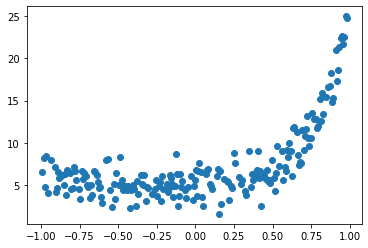

In [82]:
# plot train data
plt.scatter(x_train, y_train)
plt.show()

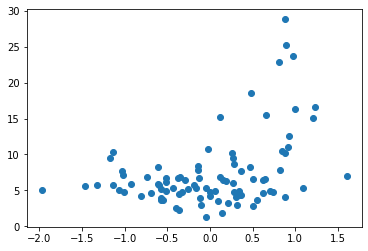

In [83]:
# plot test data
plt.scatter(x_test, y_test)
plt.show()

In [84]:
def model(X, w):
    terms = []
    for i in range(len(y_train_coeffs)):
        term = tf.multiply(w[i], tf.pow(X, i))
        terms.append(term)
    return tf.add_n(terms)

X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)
reg_lambda = tf.placeholder(tf.float32)

w = tf.Variable([0.] * len(y_train_coeffs), name="parameters")
y_model = model(X, w)

learning_rate = 0.001
training_epochs = 1000

cost = tf.add(
    tf.reduce_mean(tf.square(Y - y_model)),
    tf.multiply(reg_lambda, tf.reduce_sum(tf.abs(w))),
)

train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [85]:
acceptableError = 8.0

def comparePrediction(y_feed, y_predict):
    if np.sqrt(np.square(y_feed - y_predict)) <= acceptableError:
        return True
    return False

def calculate_accuracy(x_dataset, y_dataset, w_val, coeffs):
    acc = 0
    for ind, x in enumerate(x_dataset):
        y_predict = 5
        for i in range(len(coeffs)):
            y_predict += w_val[i] * np.power(x, i)

        if comparePrediction(y_dataset[ind], y_predict):
            acc += 1

    return acc / len(x_dataset) * 100

In [86]:
max_test_accuracy = 0
best_lambda = 0.0

# parameter equivalent for best lambda
final_w = np.array([0.] * len(y_train_coeffs))

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for lambda_val in np.linspace(0, 1, 100):
    for epoch in range(training_epochs):
        sess.run(train_op, \
             feed_dict={X: x_train, Y: y_train, reg_lambda: lambda_val})
    
    test_accuracy = \
        calculate_accuracy(x_test, y_test, sess.run(w), y_train_coeffs)
    
    if test_accuracy >= max_test_accuracy:
        final_w = sess.run(w)
        best_lambda = reg_lambda
        max_test_accuracy = test_accuracy
    
    w.assign([0.] * len(y_train_coeffs)) # reset parameters

sess.close()

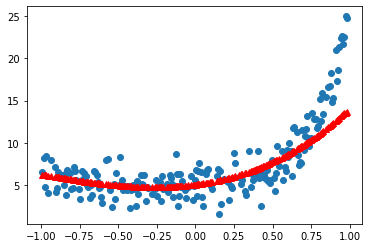

In [87]:
plt.scatter(x_train, y_train)

y_learned = 0
for i in range(len(y_train_coeffs)):
    y_learned += final_w[i] * np.power(x_train, i)

plt.plot(x_train, y_learned, "r^")
plt.show()

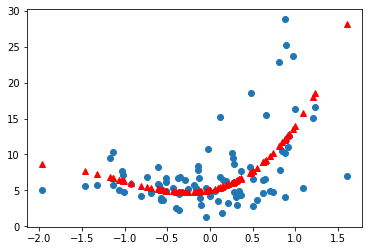

In [88]:
plt.scatter(x_test, y_test)

y_learned = 0
for i in range(len(y_train_coeffs)):
    y_learned += final_w[i] * np.power(x_test, i)

plt.plot(x_test, y_learned, "r^")
plt.show()

In [89]:
print(f"""Accuracy on training dataset \ 
    {calculate_accuracy(x_train, y_train, final_w, y_train_coeffs)}""")
print(f"""Accuracy on testing dataset \ 
    {calculate_accuracy(x_test, y_test, final_w, y_train_coeffs)}""")

Accuracy on training dataset \ 
    98.57142857142858
Accuracy on testing dataset \ 
    84.44444444444444
